In [23]:
#imports

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from wordcloud import WordCloud

In [25]:
#load preprocesssed tickets
path = 'Datasets/endava-tickets.csv'
tickets = pd.read_csv(path)
tickets.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [26]:
tickets.shape

(48549, 9)

In [27]:
# value count of each category
tickets['category'].value_counts()

4     34061
5      9634
6      2628
7       921
11      612
8       239
9       191
3       137
1        72
12       45
0         4
2         3
10        2
Name: category, dtype: int64

In [9]:
#setting column to predict
column_to_predict = 'category'

In [10]:
min_data_per_class = 5000

In [11]:
# removing poorly represented classes
text_columns = "body"  # "title" - text columns used for TF-IDF

# Removing rows related to classes represented by low amount of data
print("Shape of dataset before removing classes with less then " + str(min_data_per_class) + " rows: "+str(tickets.shape))
print("Number of classes before removing classes with less then " + str(min_data_per_class) + " rows: "+str(len(np.unique(tickets[column_to_predict]))))
bytag = tickets.groupby(column_to_predict).aggregate(np.count_nonzero)
tags = bytag[bytag.body > min_data_per_class].index
tickets = tickets[tickets[column_to_predict].isin(tags)]
print(
    "Shape of dataset after removing classes with less then "
    + str(min_data_per_class) + " rows: "
    + str(tickets.shape)
)
print(
    "Number of classes after removing classes with less then "
    + str(min_data_per_class) + " rows: "
    + str(len(np.unique(tickets[column_to_predict])))
)

Shape of dataset before removing classes with less then 5000 rows: (48549, 9)
Number of classes before removing classes with less then 5000 rows: 13
Shape of dataset after removing classes with less then 5000 rows: (43695, 9)
Number of classes after removing classes with less then 5000 rows: 2


In [12]:
# value count of each category
tickets['category'].value_counts()

4    34061
5     9634
Name: category, dtype: int64

In [13]:
labelData = tickets[column_to_predict]
data = tickets[text_columns]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labelData, test_size = 0.2)
data.dtype

dtype('O')

**Prepare data**

In [14]:
def data_preparation(data):
    class StemmedCountVectorizer(CountVectorizer):
        def biuld_analyzer(self):
            analyzer = super(StemmedCountVectorizer, self).build_analyzer()
            stemmer = SnowballStemmer("english")
            return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    count_vect = CountVectorizer()
    vectorized_data = count_vect.fit_transform(train_data)
    tfidf = TfidfTransformer()
    features = tfidf.fit_transform(vectorized_data)


In [15]:
class StemmedCountVectorizer(CountVectorizer):
    def biuld_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english")
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [16]:
# count vectorizer
count_vect = CountVectorizer()
vectorized_data = count_vect.fit_transform(train_data)
vectorized_data.shape

(34956, 11138)

In [17]:
tfidf = TfidfTransformer()
features = tfidf.fit_transform(vectorized_data)
features.shape

(34956, 11138)

In [18]:
print("Training NB classifier")
text_clf = Pipeline([
    ('vect', count_vect),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB(fit_prior=True))
])
text_clf = text_clf.fit(train_data, train_labels)

Training NB classifier


Evaluating model
              precision    recall  f1-score   support

           4       0.89      0.99      0.94      6838
           5       0.94      0.57      0.71      1901

    accuracy                           0.90      8739
   macro avg       0.92      0.78      0.83      8739
weighted avg       0.90      0.90      0.89      8739

Confusion matrix: 


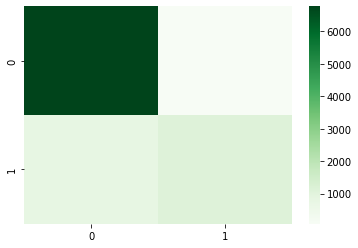

In [19]:
print("Evaluating model")
prediction = text_clf.predict(test_data)
print(classification_report(test_labels, prediction))

cf = confusion_matrix(test_labels, prediction)

sns.heatmap(cf, cmap= 'Greens')

#prediction_acc = np.mean(prediction == test_labels)
print("Confusion matrix: ")

#print("Mean " + str(prediction_acc))



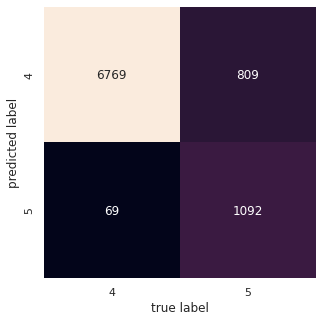

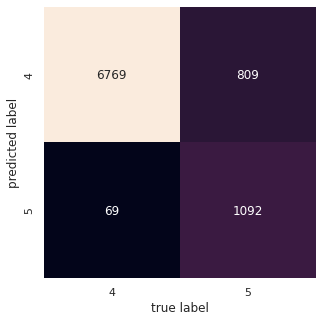

In [20]:

mat = confusion_matrix(test_labels, prediction)
plt.figure(figsize=(5, 5))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
xticklabels=np.unique(test_labels),
yticklabels=np.unique(test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.show(())

***DEPLOY***


In [21]:
from flask import Flask, render_template, request

In [22]:
app = Flask(__name__)

@app.route("/")
def hello():
    return render_template("index.html")

@app.route("/sub", methods = ['POST'])
def submit():

    if request.method == "POST":
        title = request.form["title"]
        body = request.form["body"]
    
        raw_data = pd.DataFrame([[body, title]])
        X = raw_data[0]

        y = text_clf.predict(X)
        
        predicted_category = y
        

    return render_template("submit.html", show = predicted_category)

if __name__ == "__main__":
    app.run()



 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000 (Press CTRL+C to quit)
127.0.0.1 - - [11/Apr/2022 20:12:55] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2022 20:12:56] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [11/Apr/2022 20:13:12] "POST /sub HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2022 20:13:26] "POST /sub HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2022 20:13:36] "POST /sub HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2022 20:14:08] "POST /sub HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2022 22:30:25] "POST /sub HTTP/1.1" 200 -
